In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [9]:
# leer archivo CSV

strava_jose = pd.read_csv(r"C:\Users\eduar\OneDrive\Escritorio\Master_DataScience_AI\TFM. “Predicción del rendimiento en corredores mediante técnicas de Machine Learning un enfoque aplicado al sector deportivo”\data\activities_jose_carreño.csv")

# mostrar las primeras filas del DataFrame

strava_jose.tail()

,ID de actividad,Fecha de la actividad,Nombre de la actividad,Tipo de actividad,Descripción de la actividad,Tiempo transcurrido,Distancia,Ritmo cardiaco máximo,Esfuerzo Relativo,Desplazamiento,...,Intensidad,Ritmo ajustado en pendientes promedio,Tiempo cronometrado,Ciclos en total,Recuperación,Con mascota,Competición,Carrera de larga distancia,Por una causa,Multimedia
279,15544071710,22 ago. 2025 6:19:38,Natación de mañana,Natación,NaN,1439,467,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
280,15613202413,25 ago. 2025 5:44:58,Carrera de mañana,Carrera,NaN,2702,"6,76",NaN,NaN,False,...,NaN,2.546,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
281,15613204968,28 ago. 2025 5:54:04,Natación de mañana,Natación,NaN,2771,1.100,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
282,15613205019,26 ago. 2025 5:43:57,Carrera de mañana,Carrera,NaN,3315,"7,58",NaN,NaN,False,...,NaN,3.096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
283,15661802064,1 sept. 2025 16:55:56,Caminata de noche,Caminata,NaN,2055,"1,73",NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# variable distancia a float
strava_jose['Distancia'] = strava_jose['Distancia'].replace(',', '.', regex=True).astype(float)

In [11]:
def limpiar_strava(df):
    # Renombrar columnas para facilitar el manejo
    df = df.rename(columns={
        'Fecha de la actividad': 'activity_date',
        'Tipo de actividad': 'activity_type',
        'Nombre de la actividad': 'activity_name',
        'Distancia': 'distance',
        'Tiempo transcurrido': 'elapsed_time',
        'Velocidad promedio': 'average_speed',
        'Desnivel positivo': 'elevation_gain',
        'Ritmo cardiaco promedio': 'avg_heart_rate',
        'Ritmo cardiaco máximo': 'max_heart_rate',
        'Calorías': 'calories',
        'Cadencia promedio': 'avg_cadence',
        'ID de actividad': 'activity_id',
    })

    # Convertir activity_date a datetime
    df['activity_date'] = pd.to_datetime(df['activity_date'], errors='coerce')
    df = df[(df['activity_date'].dt.year >= 2024) & (df['activity_type'] == 'Carrera')]

    if df['distance'].max() > 1000:
        df['distance_km'] = df['distance'] / 1000
    else:
        df['distance_km'] = df['distance']

    # Calcular el ritmo promedio en segundos por km
    df['avg_pace_s_per_km'] = df['elapsed_time'] / df['distance_km']

    # Calcular el ritmo en minutos por km
    df['minutes_per_km'] = df['avg_pace_s_per_km'] / 60

    # Función simple para formatear ritmo
    def format_pace(minutes_per_km):
        if pd.isna(minutes_per_km) or minutes_per_km <= 0:
            return "N/A"
        minutes = int(minutes_per_km)
        seconds = int(round((minutes_per_km - minutes) * 60))
        if seconds == 60:
            minutes += 1
            seconds = 0
        return f"{minutes}.{seconds:02d}"

    # Aplicar formato de ritmo
    df['pace_formatted'] = df['minutes_per_km'].apply(format_pace)
    # cambiarla a float
    df['pace_formatted'] = df['pace_formatted'].replace("N/A", np.nan).astype(float)

    # Nueva columna: elapsed_time en formato hh:mm:ss (sin días)
    df['elapsed_time_hms'] = pd.to_timedelta(df['elapsed_time'], unit='s').apply(lambda x: f"{int(x.total_seconds() // 3600):02}:{int((x.total_seconds() % 3600) // 60):02}:{int(x.total_seconds() % 60):02}")

    # Seleccionar solo las columnas relevantes
    columnas = [
        'activity_id', 'activity_date', 'activity_type',
        'distance_km','elapsed_time_hms',
        'pace_formatted','elevation_gain', 'avg_cadence','avg_heart_rate', 'max_heart_rate', 'calories'
    ]
    df = df[columnas]

    return df

strava_limpio = limpiar_strava(strava_jose)


C:\Users\eduar\AppData\Local\Temp\ipykernel_39540\1057672102.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['activity_date'] = pd.to_datetime(df['activity_date'], errors='coerce')


In [12]:
# añadir columna usuario

strava_limpio['user'] = 'José Carreño Alguacil'

In [13]:
strava_limpio.tail()

,activity_id,activity_date,activity_type,distance_km,elapsed_time_hms,pace_formatted,elevation_gain,avg_cadence,avg_heart_rate,max_heart_rate,calories,user
267,13732718171,2025-02-06 07:09:51,Carrera,8.09,00:41:13,5.06,15.0,87.0,NaN,NaN,549.0,José Carreño Alguacil
271,13732718508,2025-02-11 06:42:48,Carrera,7.58,00:40:30,5.21,61.0,83.0,NaN,NaN,539.0,José Carreño Alguacil
273,13732718779,2025-02-26 13:00:40,Carrera,5.88,00:23:36,4.01,22.0,90.0,NaN,NaN,386.0,José Carreño Alguacil
275,15108956265,2025-07-08 05:41:47,Carrera,8.48,00:45:58,5.25,24.0,81.0,NaN,NaN,555.0,José Carreño Alguacil
276,15172676931,2025-07-20 05:51:23,Carrera,6.26,00:28:49,4.36,19.0,84.0,NaN,NaN,386.0,José Carreño Alguacil


In [14]:
# Guardar el DataFrame limpio en la carpeta csv_clean
strava_limpio.to_csv(r"C:\Users\eduar\OneDrive\Escritorio\Master_DataScience_AI\TFM. “Predicción del rendimiento en corredores mediante técnicas de Machine Learning un enfoque aplicado al sector deportivo”\csv_clean\strava_jose_carreño_limpio.csv", index=False)

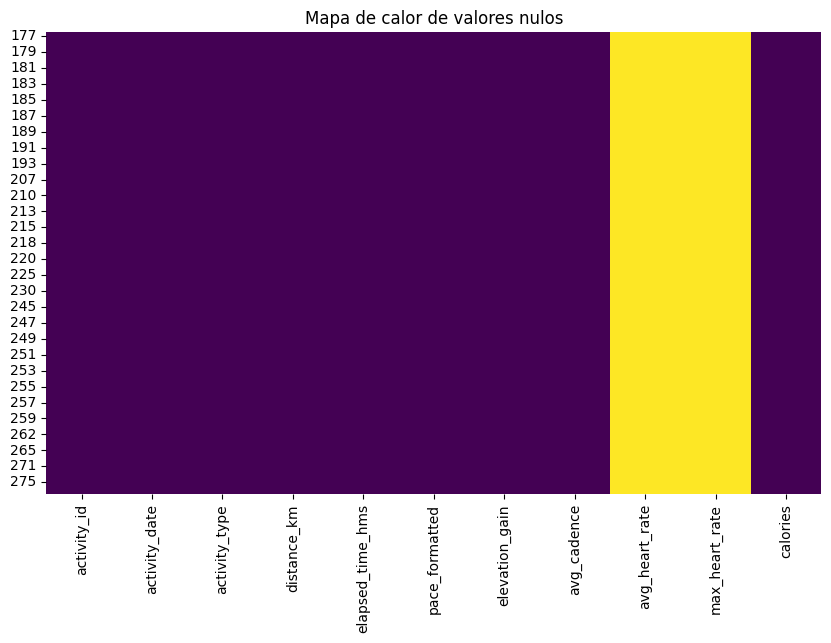

Estadísticos de variables seleccionadas:
       distance_km  pace_formatted     calories
count    58.000000       58.000000    58.000000
mean      5.365690        5.513103   372.448276
std       3.335916        1.183473   237.212184
min       0.800000        3.380000    41.000000
25%       1.942500        4.685000   133.250000
50%       5.910000        5.295000   388.500000
75%       7.090000        6.130000   501.000000
max      16.440000        9.570000  1175.000000


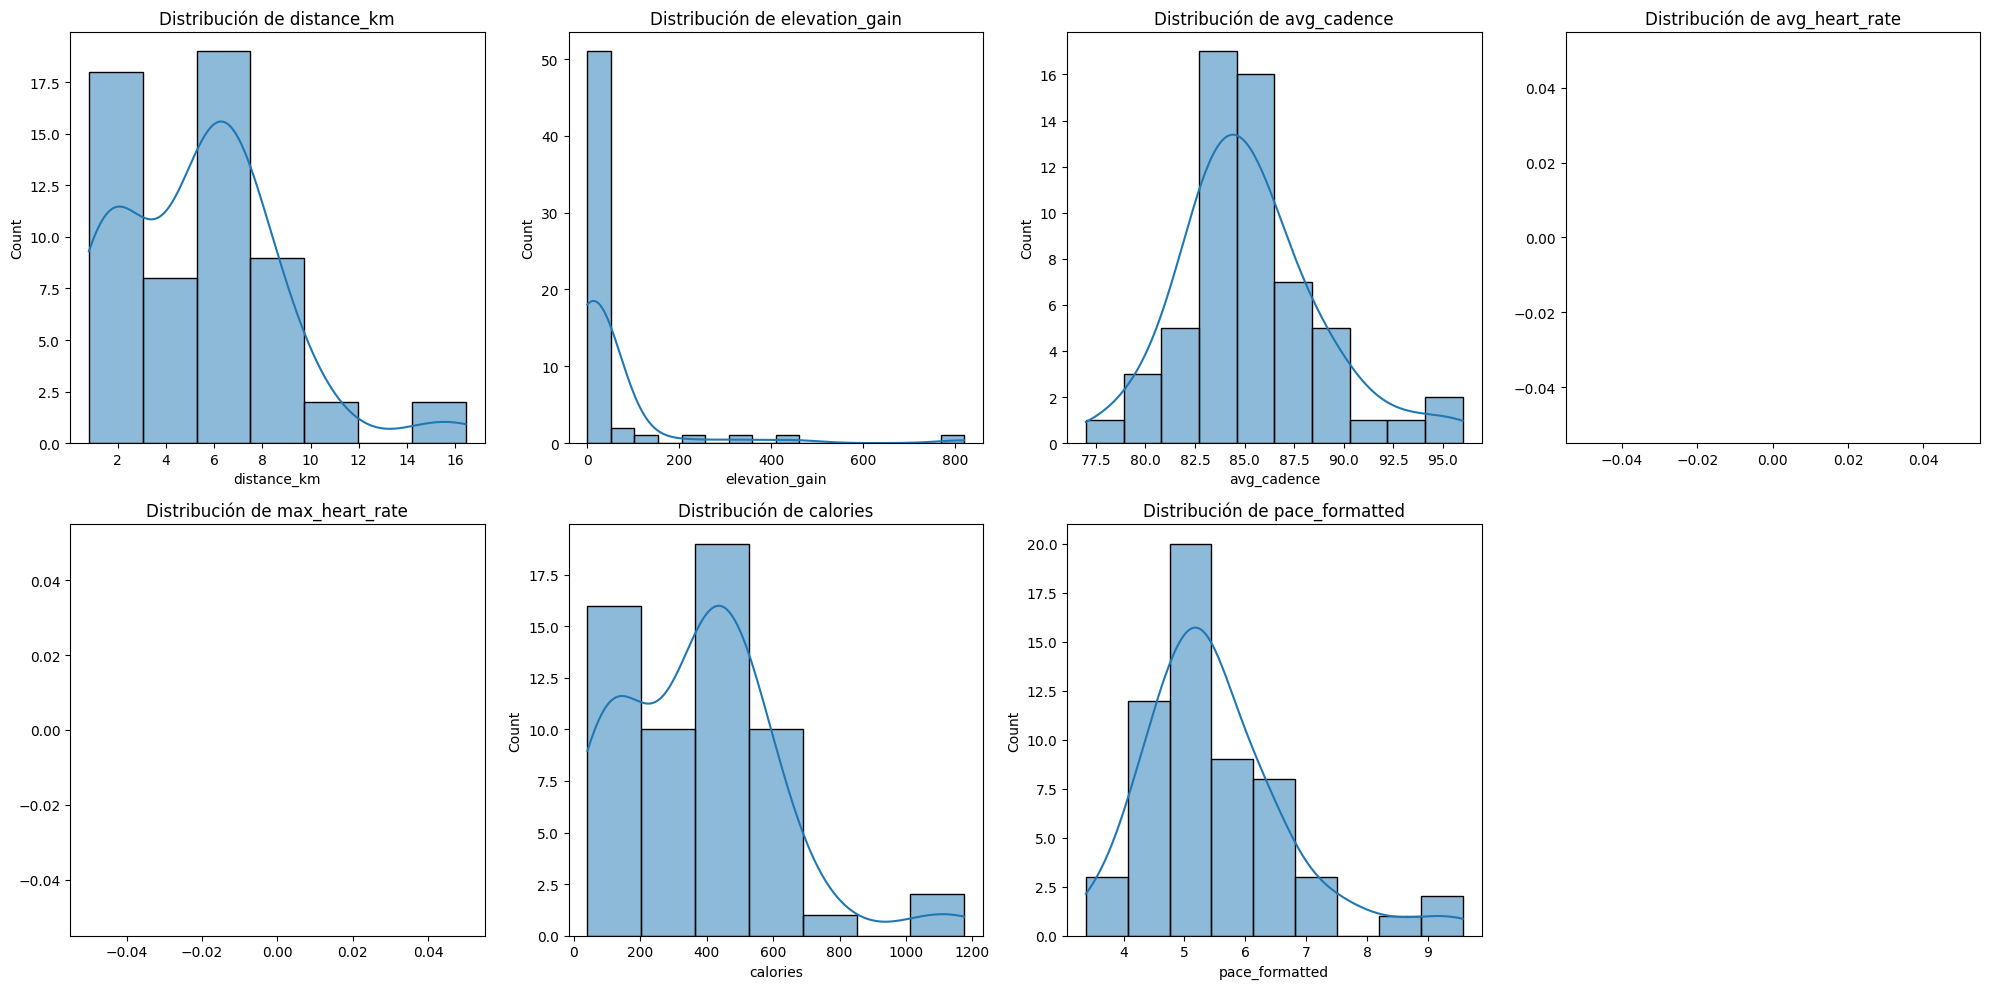

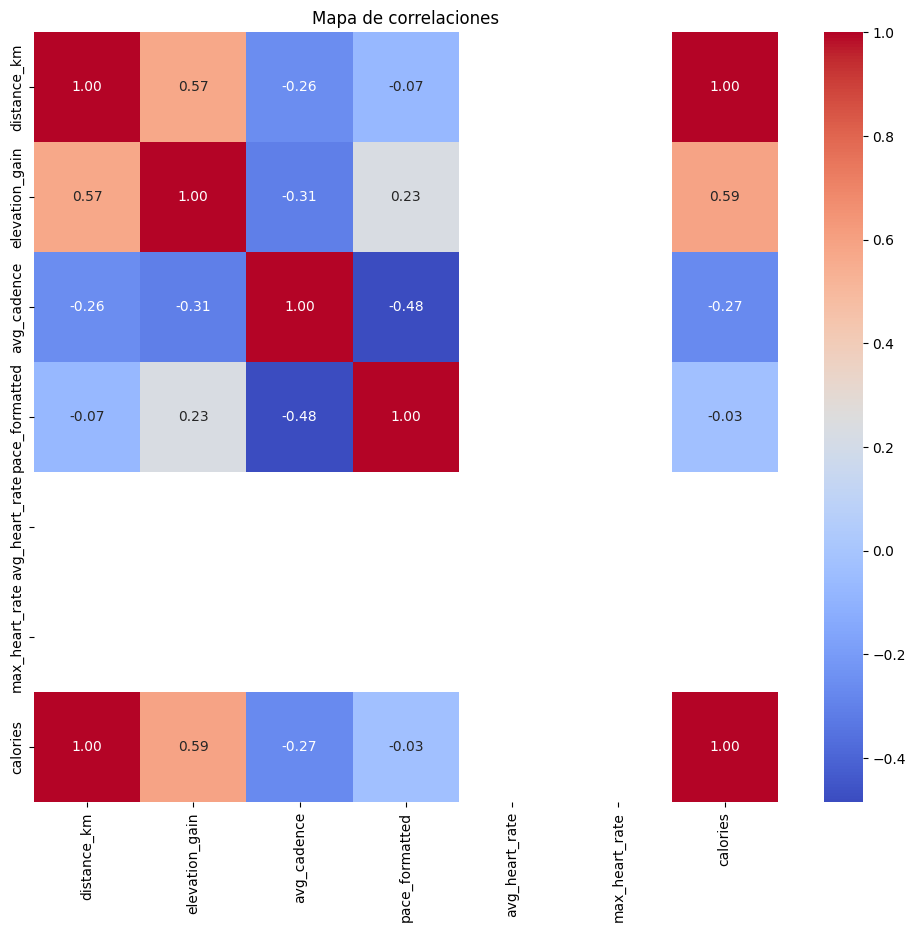

In [15]:
def EDA(data):
    # Seleccionar solo las columnas relevantes
    columnas = [
        'activity_id', 'activity_date', 'activity_type',
        'distance_km', 'elapsed_time_hms',
        'pace_formatted', 'elevation_gain', 'avg_cadence',
        'avg_heart_rate', 'max_heart_rate', 'calories'
    ]
    data = data[columnas]

    # Gráficos para ver nulos
    if data.isnull().sum().sum() == 0:
        print("No hay valores nulos en las variables seleccionadas.")
    else:
        plt.figure(figsize=(10,6))
        sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
        plt.title('Mapa de calor de valores nulos')
        plt.show()

    # Estadísticos de variables seleccionadas
    print("Estadísticos de variables seleccionadas:")
    print(data[['distance_km', 'pace_formatted', 'calories']].describe())

    # Distribución de variables continuas en una sola imagen
    dist_vars = ['distance_km', 'elevation_gain', 'avg_cadence', 'avg_heart_rate', 'max_heart_rate', 'calories', 'pace_formatted']
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
    axes = axes.flatten()

    for i, var in enumerate(dist_vars):
        if i < len(axes):
            ax = axes[i]
            if data[var].dtype == 'object':
                data[var].value_counts().plot(kind='bar', ax=ax)
                ax.set_ylabel('Frecuencia')
            else:
                sns.histplot(data[var].dropna(), kde=True, ax=ax)
            ax.set_title(f'Distribución de {var}')

    # Eliminar el subplot vacío si hay menos variables que subplots
    for j in range(len(dist_vars), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    # Mapa de correlaciones (todas las variables numéricas relevantes)
    plt.figure(figsize=(12,10))
    corr_vars = ['distance_km', 'elevation_gain', 'avg_cadence','pace_formatted', 'avg_heart_rate', 'max_heart_rate', 'calories']
    corr = data[corr_vars].corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Mapa de correlaciones')
    plt.show()

EDA(strava_limpio)
